In [ ]:
!pip install umap-learn
!pip install gensim
!pip install spacy
!pip install scipy
!pip install yellowbrick
!pip install bokeh

## Import Dependencies

In [2]:
import pandas as pd
import glob
import numpy as np
import pandas as pd

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_lg

from pprint import pprint
import scipy.sparse as ss
import matplotlib.pyplot as plt
import tkinter

import matplotlib
matplotlib.use('TkAgg')
import yellowbrick
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import umap.umap_ as umap


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Create and Clean Dataset

In [3]:
##define nlp and start cleaning data
nlp= spacy.load("en")

# List of stop words to equalize data
stop_list = []

# Updates spaCy's default stop words list with my additional words. 
nlp.Defaults.stop_words.update(stop_list)

# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True


In [4]:
#clean data

def lemmatizer(doc):
    # This takes in a doc of tokens from the NER and lemmatizes them. 
    # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
def remove_stopwords(doc):
    # This will remove stopwords and punctuation.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

# The add_pipe function appends our functions to the default pipeline.
nlp.add_pipe(lemmatizer,name='lemmatizer',after='ner')
nlp.add_pipe(remove_stopwords, name="stopwords", last=True)

In [5]:
# Merging csv files (without repeating header)
interesting_files = glob.glob("*.csv") 
df = pd.concat((pd.read_csv(f, header = 0) for f in interesting_files))
df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,Author,Body,Date,Subreddit,Title,URL,Unnamed: 0
0,NaN,Uk cahms service shit sure schizophrenia fucki...,NaN,Depression,NaN,NaN,0.0
1,NaN,anybody luck holistic treatment gut health met...,NaN,Depression,NaN,NaN,1.0
2,NaN,leave bed 4:20pm work 5:00pm feel like walk dr...,NaN,Depression,NaN,NaN,2.0
3,NaN,want help people care feel right like wrong bo...,NaN,Depression,NaN,NaN,3.0
4,NaN,obviously want unhappy want depressed miserabl...,NaN,Depression,NaN,NaN,4.0
...,...,...,...,...,...,...,...
7149,Prestoric_user,I want to sell my ps4 since i dont use it anym...,1.585612e+09,Anxiety,I want to sell my console but its hard,/r/Anxiety/comments/fs251x/i_want_to_sell_my_c...,NaN
7150,Gametest014,So yesterday(this morning) I went to sleep at ...,1.585612e+09,Anxiety,Just looking for advice,/r/Anxiety/comments/fs260r/just_looking_for_ad...,NaN
7151,throw-away-3005,I took the first bath in our new house and it ...,1.585612e+09,Anxiety,My first bath,/r/Anxiety/comments/fs27t3/my_first_bath/,NaN
7152,AnxiousFishermen,Without meaning too i always find my self cros...,1.585613e+09,Anxiety,Anyone else always crossing their legs?,/r/Anxiety/comments/fs28s1/anyone_else_always_...,NaN


In [6]:
#create a list of documents (list of lists) 
text_doc = df['Body'].tolist()

In [11]:
doc_list = []
# Iterates through each article in the corpus.
for doc in text_doc:
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp(str(doc))
    doc_list.append(pr)

In [12]:
#However doc_list gives us each post as a list, with individual words being elements 
from nltk.tokenize.treebank import TreebankWordDetokenizer
empt = [];
for doc in doc_list:
    a1 = TreebankWordDetokenizer().detokenize(doc)
    empt.append(a1)

subreddit = [];
for sub in df['Subreddit']:
    a2 = sub
    subreddit.append(a2)
    
d = list(zip(empt,subreddit))
#df_doc_dep is a dataframe that has cleaned posts from the subreddits.
#all the 'removed' posts are gone and all the stopwords in the individual posts are gone! 

#both doc_list and df_doc are important (at least I think so :D)

data = pd.DataFrame(d, columns = ['Body', 'Subreddit'])
data

,Body,Subreddit
0,Uk cahms service shit sure schizophrenia fucki...,Depression
1,anybody luck holistic treatment gut health met...,Depression
2,leave bed 4:20pm work 5:00pm feel like walk dr...,Depression
3,want help people care feel right like wrong bo...,Depression
4,obviously want unhappy want depress miserable ...,Depression
...,...,...
56189,want sell ps4 use anymore want money hard pers...,Anxiety
56190,yesterday(this morning sleep midnight 12 wake ...,Anxiety
56191,bath new house cause flood basement live boyfr...,Anxiety
56192,mean find self cross leg,Anxiety


In [13]:
data.to_csv('alldata.csv')

In [14]:
# from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer


# Load the data and create document vectors
corpus = data.Body

tfidf = TfidfVectorizer()

X = tfidf.fit_transform(corpus)
y = data.Subreddit

# Create the visualizer and draw the vectors
fig, ax = plt.subplots(figsize=(30,20))
tsne = TSNEVisualizer()
tsne.fit(X, y)
tsne.show(outpath = 't_sne_lg.jpg')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


In [17]:
from yellowbrick.text import DispersionPlot
from yellowbrick.datasets import load_hobbies

# Load the text data
corpus = data.Body

# Create a list of words from the corpus text
text = [doc.split() for doc in corpus]

# Choose words whose occurence in the text will be plotted
target_words = ['virus', 'covid19', 'COVID', 'coronavirus', 'Coronavirus']
labels = data.Subreddit

# Create the visualizer and draw the plot
visualizer = DispersionPlot(target_words)
visualizer.fit(text)
visualizer.show(outpath = 'lex_lg.jpg')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


In [32]:
import umap
import umap.plot

# Used to get the data
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Some plotting libraries
import matplotlib.pyplot as plt
%matplotlib notebook
from bokeh.plotting import show, save, output_notebook, output_file
from bokeh.resources import INLINE
output_notebook(resources=INLINE)

Loading BokehJS ...

In [37]:
import umap.umap_ as umap
reducer=umap.UMAP()

In [38]:
tfidf_vectorizer = TfidfVectorizer(min_df=5, stop_words='english')
tfidf_word_doc_matrix = tfidf_vectorizer.fit_transform(data.Body)

In [39]:
tfidf_word_doc_matrix

<56194x12253 sparse matrix of type '<class 'numpy.float64'>'
	with 2315634 stored elements in Compressed Sparse Row format>

In [40]:
embedding = umap.UMAP(n_components=2, metric='hellinger').fit(tfidf_word_doc_matrix)

<IPython.core.display.Javascript object>


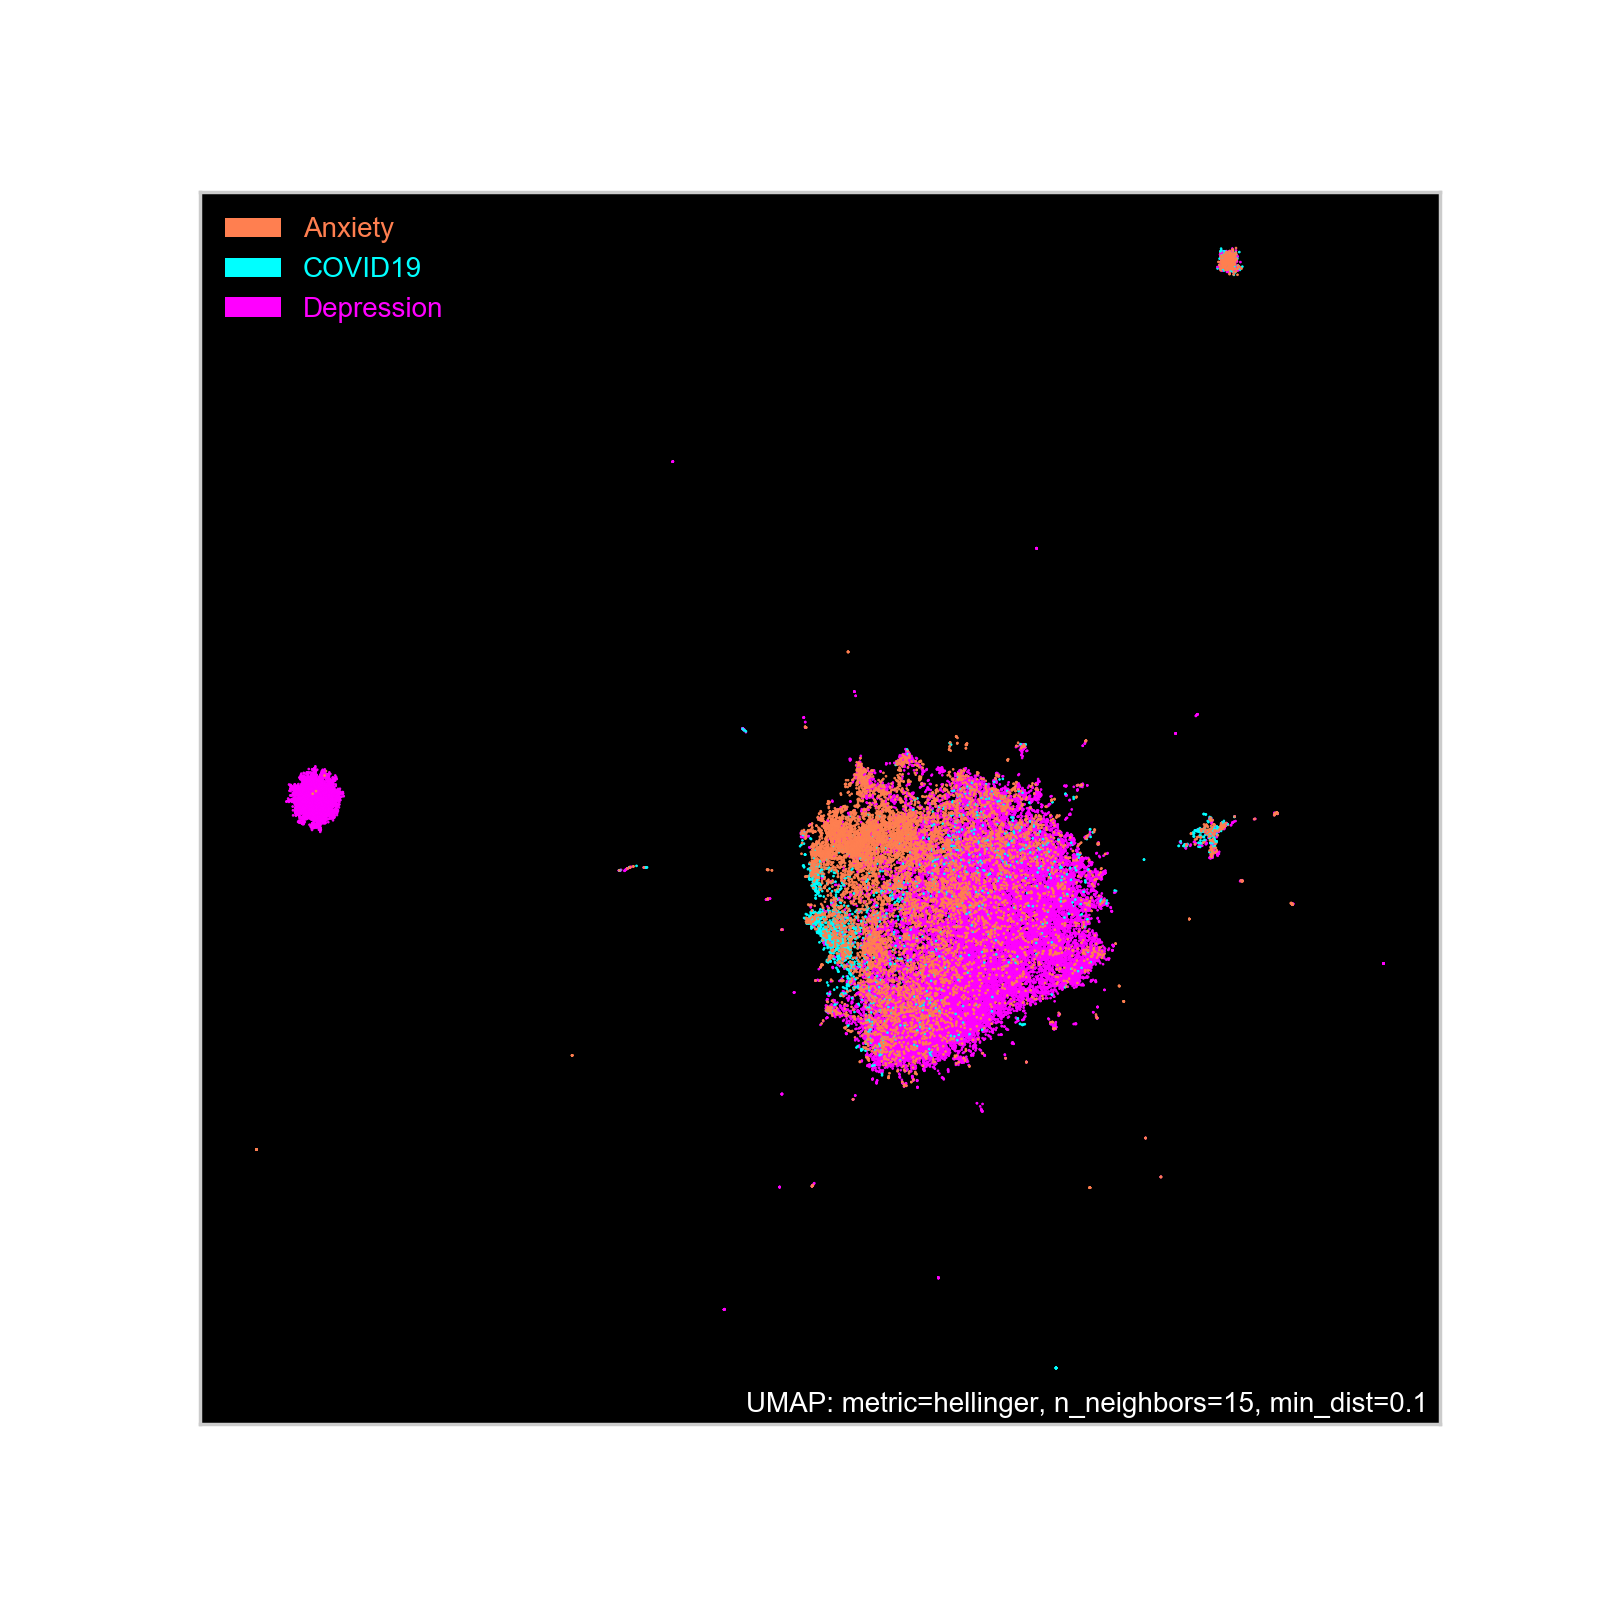

In [100]:
colors = ['coral', 'aqua', 'magenta'];
fig = umap.plot.points(embedding, labels=data['Subreddit'], color_key= colors,   background='black', show_legend=True)

leg = fig.get_legend();
for color,text in zip(colors,leg.get_texts()):
    text.set_color(color)

In [101]:
import gensim
import numpy as np
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
import plotly.offline as plt
import plotly.graph_objs as go
plt.init_notebook_mode(connected=True)
from gensim.models import Word2Vec
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

In [102]:
model = wv

In [103]:
def get_coordinates(model, words):
    arr = np.empty((0,300), dtype='f')
    labels = []
    for wrd_score in words:
        try:
            wrd_vector = model[wrd_score]
            arr = np.append(arr, np.array([wrd_vector]), axis=0)
            labels.append(wrd_score)
        except:
            pass
    tsne = TSNE(n_components=3, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    z_coords = Y[:, 2]
    return x_coords, y_coords, z_coords

In [105]:
##can't figure out how to give different subreddits different colors. Array is reduced in size for some reason 
##and not sure how to configure our data with this...
words = data.Body

x, y, z = get_coordinates(model, words)

plot = [go.Scatter3d(x = x,
                    y = y,
                    z = z,
                    mode = 'markers+text',
                    textposition='bottom center',
                    hoverinfo = 'text',
                    marker=dict(size=5,opacity=0.7))]

layout = go.Layout(title='Mental Health Subreddits')
fig = go.Figure(data=plot, layout=layout)
plt.iplot(fig)

